# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Conv1DTranspose, Reshape, UpSampling1D
from tensorflow.keras.optimizers import Adam

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, UpSampling1D, Conv1DTranspose, RepeatVector, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-12-16 19:25:05.504335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 19:25:05.504372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 19:25:05.505512: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 19:25:05.512453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 19:25:06.461307: W tensorflow/compiler/tf2

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2



2023-12-16 19:25:08.795560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-16 19:25:08.796259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


## 50 Subjects of single ECG autoencoder

In [2]:
subjects = pd.read_csv('../scripting/ecg_downloader/data/merged_ecg_data.csv')

In [3]:
subjects.shape

(7500000, 1)

In [4]:
subjects_reshaped = subjects.values.reshape((250, 30000, 1))
subjects_reshaped.shape

(250, 30000, 1)

In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-12-16 19:25:09.693389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-16 19:25:09.693589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [6]:
with strategy.scope():
    encoder_1 = tf.keras.models.Sequential([
        Conv1D(64, 250, activation='relu', padding='same', input_shape=(30000, 1)),
        Dense(32, activation='relu'),
        MaxPooling1D(),
        Conv1D(32, 250, activation='relu', padding='same'),
        Dense(16, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(8)
    ], name='encoder_1')

    encoder_2 = tf.keras.models.Sequential([
        RepeatVector(30000),
        Reshape((30000, 1, 8)),
        TimeDistributed(Conv1DTranspose(16, 250, activation='relu', padding='same')),
        TimeDistributed(Conv1DTranspose(32, 250, activation='relu', padding='same')),
        TimeDistributed(Conv1DTranspose(64, 250, activation='relu', padding='same')),
        Reshape((30000, 64))
    ], name='encoder_2')

    custom_optimizer = Adam(learning_rate=0.001)
    symmetrical_encoder = Sequential([encoder_1, encoder_2])
    symmetrical_encoder.compile(optimizer=custom_optimizer, loss="mse")

history = symmetrical_encoder.fit(subjects_reshaped, subjects_reshaped, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 16 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 16 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-12-16 19:25:14.118347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-16 19:25:14.144998: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-16 19:25:20.992258: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1920000
in_depths: 16
out_depths: 8
in: 1
in: 2
data_format: 1
filter: 1
filter: 250
filter: 16
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 124
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_5.2 with 12799967232B RAM, 24 cores, 1076000KHz clock, 3505000KHz mem clock, 3145728B L2$"
version: 3

2023-12-16 19:25:21.133416: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1920000
in_depths: 16
out_depths: 8
in: 1
in: 2
data_format: 1
filter: 1


1/2 [==============>...............] - ETA: 2:28 - loss: 0.1615

2023-12-16 19:27:46.061754: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1830000
in_depths: 16
out_depths: 8
in: 1
in: 2
data_format: 1
filter: 1
filter: 250
filter: 16
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 124
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_5.2 with 12799967232B RAM, 24 cores, 1076000KHz clock, 3505000KHz mem clock, 3145728B L2$"
version: 3

2023-12-16 19:27:46.234857: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1830000
in_depths: 16
out_depths: 8
in: 1
in: 2
data_format: 1
filter: 1
filter: 250
filter: 16
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 124
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_5.2 with 12798132224B RAM, 24 cores, 1076000KHz clock, 3505000KHz mem clock, 3145728B L2$

2/2 [==============================] - ETA: 0s - loss: 0.1570  INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2/2 [==============================] - 292s 144s/step - loss: 0.1570
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.1569INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:

In [8]:
with strategy.scope():
    decoder = Sequential([
        Reshape((8, 1), input_shape=(8,)),
        Conv1DTranspose(8, 29993, activation='relu', padding='valid'),
        Dense(16, activation='relu'),
        Conv1DTranspose(16, 250, activation='relu', padding='same'),
        Dense(32, activation='relu'),
        Conv1DTranspose(32, 250, activation='relu', padding='same'),
        Dense(64, activation='relu'),
        Conv1DTranspose(1, 250, activation='linear', padding='same')
    ], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 8, 1)              0         
                                                                 
 conv1d_transpose_3 (Conv1D  (None, 30000, 8)          239952    
 Transpose)                                                      
                                                                 
 dense_3 (Dense)             (None, 30000, 16)         144       
                                                                 
 conv1d_transpose_4 (Conv1D  (None, 30000, 16)         64016     
 Transpose)                                                      
                                                                 
 dense_4 (Dense)             (None, 30000, 32)         544       
                                                                 
 conv1d_transpose_5 (Conv1D  (None, 30000, 32)         2560

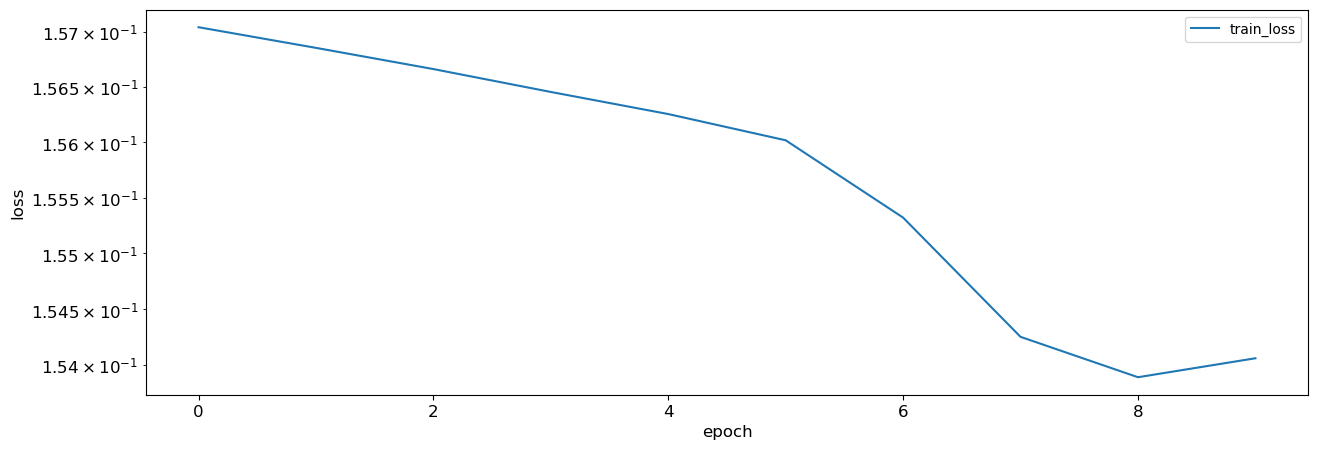

In [9]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Inference

In [10]:
subject_60 = pd.read_csv('../scripting/ecg_downloader/data/output_blobs_case_60/all_subject_60_blobs.csv')

In [11]:
subject_60.shape

(150000, 1)

In [12]:
subject_60_reshaped = subject_60.values.reshape((5, 30000, 1))
subject_60_reshaped.shape

(5, 30000, 1)

In [13]:
latent_representations = encoder_1.predict(subject_60_reshaped)
latent_representations

1/1 [==============================] - 1s 1s/step


array([[ 55.72416  ,  82.67009  , -26.77422  ,  87.160934 , -43.287125 ,
         76.59911  ,  89.0426   , -50.381474 ],
       [ 87.993416 , 121.52829  , -51.035854 , 125.22867  , -61.65792  ,
        103.226776 , 123.03574  , -81.20357  ],
       [ 12.503287 ,  22.956526 ,  -4.0211315,  23.350653 ,  -8.532124 ,
         17.805246 ,  22.678665 , -11.135566 ],
       [  8.830195 ,  16.041977 ,  -3.7030296,  16.989737 ,  -7.0398493,
         13.303135 ,  16.763971 ,  -8.284057 ],
       [ 28.816492 ,  46.826214 , -14.524847 ,  47.672657 , -24.062557 ,
         39.628433 ,  47.886612 , -28.434565 ]], dtype=float32)

In [14]:
generated_ecgs = decoder.predict(latent_representations)
generated_ecgs_reshaped = generated_ecgs.reshape((-1, 1))
generated_ecgs_reshaped.shape

1/1 [==============================] - 2s 2s/step


(150000, 1)

Text(0, 0.5, 'Signal Value')

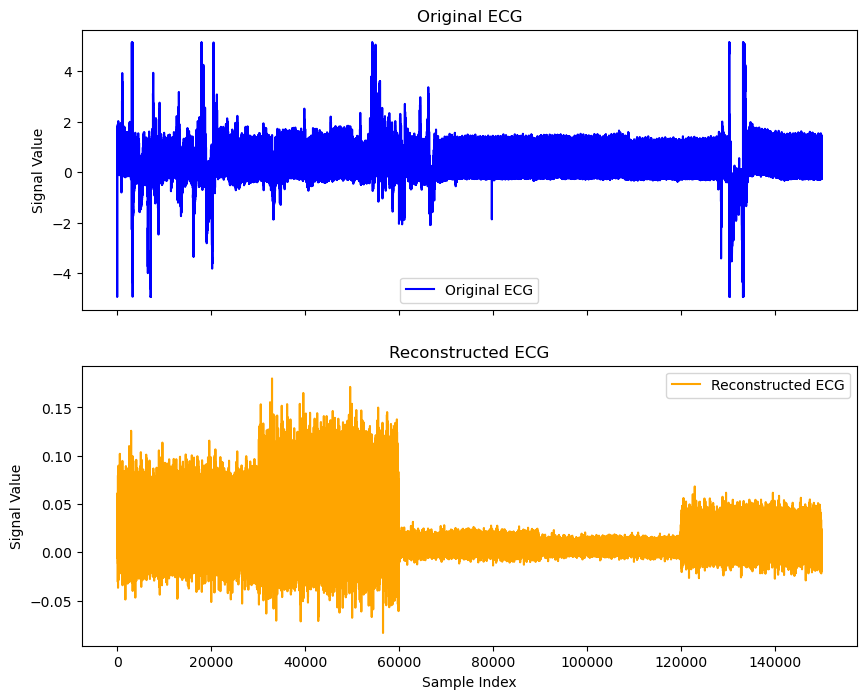

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(subject_60, label='Original ECG', color='blue')
axs[0].legend()
axs[0].set_title('Original ECG')
axs[0].set_ylabel('Signal Value')

axs[1].plot(generated_ecgs_reshaped, label='Reconstructed ECG', color='orange')
axs[1].legend()
axs[1].set_title('Reconstructed ECG')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Signal Value')

In [16]:
mse = np.mean(np.square(subject_60 - generated_ecgs_reshaped))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.4176707673457744
